#Image classification of tiny-imagenet dataset using Resnet18 CNN model , albumentation image augmentation, OnecycleLR and gradcam image

### Submitted by Deepak Hazarika  , Parinita Bora , Gurudatta

In [1]:
import time;

localtime = time.asctime(time.localtime(time.time()))
print ("Local current time :", localtime)

Local current time : Sat Oct 17 17:55:30 2020


In [1]:
!python --version

Python 3.6.9


In [2]:
!pip install PyDrive

## Import pydrive modules

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [4]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)




## Upload the tiny-imagenet image files from google drive to colab

Instead of downloading the tiny-imagenet dataset from web , a copy is saved in google drive.

In [5]:
downloaded = drive.CreateFile({'id':"1dpTEHReOEcPXhcVZsK17gn4zOg7YzDaU"})   # replace the id with id of file you want to access
downloaded.GetContentFile('tiny-imagenet-200.zip')

In [6]:
from zipfile import ZipFile

## Extract the images into a local folder

In [7]:
with ZipFile('/content/tiny-imagenet-200.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

### Initialize the parameters 

The input from LRfinder is used to set the max lr and min lr for OneCycle LR policy.

*   max_lr = 2 * (0.022)
*   min_lr = max_lr / 5
*   stepsize = 5 epoch





In [8]:
EPOCHS = 34
MLTPR = 2
BATCH_SIZE = MLTPR*128 
WEIGHT_DECAY = 1e-2
TRAIN_DATASET_SIZE = 50000
BUCKET_SIZE = 5
NUMBER_OF_BATCHES =  TRAIN_DATASET_SIZE // BATCH_SIZE
NUMBER_OF_BUCKETS = NUMBER_OF_BATCHES // BUCKET_SIZE
DATAFOLDER = "/content/tiny-imagenet-200/"
NUM_LR_FINDER_ITER = 5859 # (i epoch = 50000/batch size , number of iter = iter per epoch * epoch , 50000/128 = 301 , 1954 = 391 * 5)
END_LR = MLTPR* 0.022
START_LR = 1e-5
FACTOR=5
NUMBER_OF_STEPS =4.5
STEPSIZE = EPOCHS//NUMBER_OF_STEPS
ANNEAL_EPOCH = 2

## Import the model library from https://github.com/tfdeepnet/visionlib.git

In [9]:
!git clone https://github.com/tfdeepnet/visionlib.git

Cloning into 'visionlib'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 472 (delta 68), reused 68 (delta 34), pack-reused 365
Receiving objects: 100% (472/472), 133.27 KiB | 847.00 KiB/s, done.
Resolving deltas: 100% (290/290), done.


In [10]:
!pip install -e /content/visionlib 


Obtaining file:///content/visionlib
  Running setup.py develop for visionlib


In [11]:
import visionlib.models as vl
import visionlib.utils as utl
#import visionlib.albumentations as A


In [12]:
%matplotlib inline

## Import the libraries

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import cv2
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

## Prepare a list of albumentation for train and test data 

Calculate the channel mean and channel std. deviation for train and test dataset, apply the following transformation for image augmentation.

1.   Pad to image to increase the image size to 70x70 from 64x64
2.   RandomCrop to size 64, 64
3.   HorizontalFlip
4.   Rotate the image by +- 10 degree
5.   RandomContrast
6.   Cutout



In [14]:
import albumentations as A

train_channel_means = (0.48061935, 0.44014175, 0.38953937)
train_channel_stdevs = (0.04611376, 0.04451072, 0.04527754)

test_channel_means = (0.48001613, 0.44046918, 0.38986861)
test_channel_stdevs = (0.04581521, 0.04429793, 0.04498989)

train_transform_list = [A.PadIfNeeded (min_height=72, min_width=72,border_mode=cv2.BORDER_CONSTANT, value=0 , always_apply=True),
                        A.RandomCrop(64, 64),
                        A.HorizontalFlip(),
                        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.9, rotate_limit=10, p=0.3),
                        A.RandomContrast (),
                        A.Normalize(mean=train_channel_means, std=train_channel_stdevs),
                        A.Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p=1)]
# Test Phase transformations
test_transform_list = [A.Normalize(mean=test_channel_means, std=test_channel_stdevs)]

##  Use the loaddata utility from visionlib library to load train and test data

In [15]:
trainloader, testloader = utl.loadalbumentationdata(DATAFOLDER , BATCH_SIZE , train_transform_list, test_transform_list )


classes = ('Egyptian cat' ,'reel' ,'volleyball' ,'rocking chair' ,'lemon' ,'bullfrog' ,'basketball' ,'cliff' ,'espresso' ,'plunger' ,'parking meter' ,'German shepherd' ,'dining table' ,'monarch' ,'brown bear' ,'school bus' ,'pizza' ,'guinea pig' ,'umbrella' ,'organ' ,'oboe' ,'maypole' ,'goldfish' ,'potpie' ,'hourglass' ,'seashore' ,'computer keyboard' ,'Arabian camel' ,'ice cream' ,'nail' ,'space heater' ,'cardigan' ,'baboon' ,'snail' ,'coral reef' ,'albatross' ,'spider web' ,'sea cucumber' ,'backpack' ,'Labrador retriever' ,'pretzel' ,'king penguin' ,'sulphur butterfly' ,'tarantula' ,'lesser panda' ,'pop bottle' ,'banana' ,'sock' ,'cockroach' ,'projectile' ,'beer bottle' ,'mantis' ,'freight car' ,'guacamole' ,'remote control' ,'European fire salamander' ,'lakeside' ,'chimpanzee' ,'pay-phone' ,'fur coat' ,'alp' ,'lampshade' ,'torch' ,'abacus' ,'moving van' ,'barrel' ,'tabby' ,'goose' ,'koala' ,'bullet train' ,'CD player' ,'teapot' ,'birdhouse' ,'gazelle' ,'academic gown' ,'tractor' ,'ladybug' ,'miniskirt' ,'golden retriever' ,'triumphal arch' ,'cannon' ,'neck brace' ,'sombrero' ,'gasmask' ,'candle' ,'desk' ,'frying pan' ,'bee' ,'dam' ,'spiny lobster' ,'police van' ,'iPod' ,'punching bag' ,'beacon' ,'jellyfish' ,'wok' ,'potter\'s wheel' ,'sandal' ,'pill bottle' ,'butcher shop' ,'slug' ,'hog' ,'cougar' ,'crane' ,'vestment' ,'dragonfly' ,'cash machine' ,'mushroom' ,'jinrikisha' ,'water tower' ,'chest' ,'snorkel' ,'sunglasses' ,'fly' ,'limousine' ,'black stork' ,'dugong' ,'sports car' ,'water jug' ,'suspension bridge' ,'ox' ,'ice lolly' ,'turnstile' ,'Christmas stocking' ,'broom' ,'scorpion' ,'wooden spoon' ,'picket fence' ,'rugby ball' ,'sewing machine' ,'steel arch bridge' ,'Persian cat' ,'refrigerator' ,'barn' ,'apron' ,'Yorkshire terrier' ,'swimming trunks' ,'stopwatch' ,'lawn mower' ,'thatch' ,'fountain' ,'black widow' ,'bikini' ,'plate' ,'teddy' ,'barbershop' ,'confectionery' ,'beach wagon' ,'scoreboard' ,'orange' ,'flagpole' ,'American lobster' ,'trolleybus' ,'drumstick' ,'dumbbell' ,'brass' ,'bow tie' ,'convertible' ,'bighorn' ,'orangutan' ,'American alligator' ,'centipede' ,'syringe' ,'go-kart' ,'brain coral' ,'sea slug' ,'cliff dwelling' ,'mashed potato' ,'viaduct' ,'military uniform' ,'pomegranate' ,'chain' ,'kimono' ,'comic book' ,'trilobite' ,'bison' ,'pole' ,'boa constrictor' ,'poncho' ,'bathtub' ,'grasshopper' ,'walking stick' ,'Chihuahua' ,'tailed frog' ,'lion' ,'altar' ,'obelisk' ,'beaker' ,'bell pepper' ,'bannister' ,'bucket' ,'magnetic compass' ,'meat loaf' ,'gondola' ,'standard poodle' ,'acorn' ,'lifeboat' ,'binoculars' ,'cauliflower' ,'African elephant' )

Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img shape  torch.Size([256, 3, 64, 64])


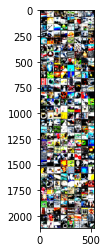

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("img shape " , images.shape)


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Instantiate a Resnet18 model to train and test the tiny-imagenet dataset


In [17]:
net = vl.ResNet18(num_classes=200)

### Get the model summary alongwith the recepive field at each layer

In [18]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

utl.summary(net.to(device), input_size=(3, 64, 64))

cuda
-----------------------------------------------------------------------------------------------
        Layer (type) |              Output Shape |         Param # |          RF out |         Jump in
            Conv2d-1 |          [-1, 64, 64, 64] |           1,728 |               3 |               1
       BatchNorm2d-2 |          [-1, 64, 64, 64] |             128 |               0 |               0
            Conv2d-3 |          [-1, 64, 64, 64] |          36,864 |               5 |               1
       BatchNorm2d-4 |          [-1, 64, 64, 64] |             128 |               0 |               0
            Conv2d-5 |          [-1, 64, 64, 64] |          36,864 |               7 |               1
       BatchNorm2d-6 |          [-1, 64, 64, 64] |             128 |               0 |               0
        BasicBlock-7 |          [-1, 64, 64, 64] |               0 |               0 |               0
            Conv2d-8 |          [-1, 64, 64, 64] |          36,864 |       

(tensor(11271432), tensor(11271432))

https://towardsdatascience.com/adaptive-and-cyclical-learning-rates-using-pytorch-2bf904d18dee

## Plot CyclicalLR graph 

[0.008799999999999999, 0.017599999999999998, 0.026399999999999996, 0.035199999999999995, 0.044, 0.035199999999999995, 0.026399999999999996, 0.017599999999999998, 0.008799999999999999, 0.017599999999999998, 0.026399999999999996, 0.035199999999999995, 0.044, 0.035199999999999995, 0.026399999999999996, 0.017599999999999998, 0.008799999999999999, 0.017599999999999998, 0.026399999999999996, 0.035199999999999995, 0.044, 0.035199999999999995, 0.026399999999999996, 0.017599999999999998, 0.008799999999999999]


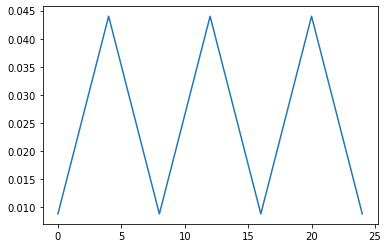

In [19]:
import math

yl = []
for it in range(24+1):
  lro = utl.cyclical_lr(4, min_lr=END_LR/FACTOR, max_lr=END_LR)(it)
  yl.append(lro)

plt.plot(yl)
print(yl)

## Plot OneCycleLr graph

[0.008799999999999999, 0.013828571428571424, 0.018857142857142854, 0.023885714285714284, 0.02891428571428571, 0.033942857142857136, 0.03897142857142856, 0.044, 0.04274285714285714, 0.04148571428571428, 0.04022857142857142, 0.038971428571428574, 0.03771428571428571, 0.036457142857142855, 0.035199999999999995, 0.033942857142857136, 0.03268571428571428, 0.03142857142857142, 0.03017142857142857, 0.02891428571428571, 0.027657142857142852, 0.026399999999999996, 0.02514285714285714, 0.023885714285714284, 0.02262857142857143, 0.02137142857142857, 0.02011428571428571, 0.018857142857142854, 0.017599999999999998, 0.01634285714285714, 0.015085714285714286, 0.01382857142857143, 0.0028285714285714273, 0.0018857142857142848]


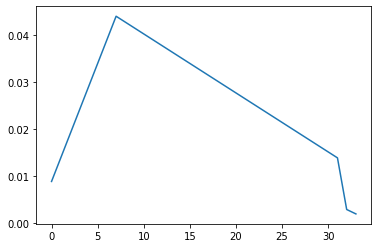

In [20]:
yl = []
for it in range(EPOCHS):
  lro = utl.one_Cycle_lr(STEPSIZE, EPOCHS, ANNEAL_EPOCH, min_lr=END_LR/FACTOR, max_lr=END_LR)(it)
  yl.append(lro)

plt.plot(yl)
print(yl)

## Apply the optimum LR found by LR finder

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1.)
clr = utl.one_Cycle_lr(STEPSIZE, EPOCHS, ANNEAL_EPOCH, min_lr=END_LR/FACTOR, max_lr=END_LR)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, [clr])

## Train the network for 34 epochs



In [22]:
train_loss = [] 
train_acc = []
test_loss = []
test_acc = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print("Epoch:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
    utl.train(epoch , trainloader, optimizer, net, criterion, NUMBER_OF_BUCKETS , device )
    test_loss,test_acc = utl.test(testloader, net, criterion , device )
    train_loss,train_acc = utl.train_metrics(trainloader, net, criterion , device )
    scheduler.step()#test_acc[-1])            

print('Finished Training')

  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 1 LR: 0.008799999999999999


Loss=4.749485015869141 Batch_id=300 Accuracy=4.11: 100%|██████████| 301/301 [05:22<00:00,  1.07s/it]



Test set: Average loss: 0.0183, Accuracy: 2029/33000 (6.15%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 2 LR: 0.013828571428571424


Loss=4.417876243591309 Batch_id=300 Accuracy=7.50: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0176, Accuracy: 2488/33000 (7.54%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 3 LR: 0.018857142857142854


Loss=4.2847490310668945 Batch_id=300 Accuracy=10.82: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0161, Accuracy: 4287/33000 (12.99%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 4 LR: 0.023885714285714284


Loss=3.9003853797912598 Batch_id=300 Accuracy=13.93: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0161, Accuracy: 3960/33000 (12.00%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 5 LR: 0.02891428571428571


Loss=3.659365653991699 Batch_id=300 Accuracy=17.05: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0141, Accuracy: 6239/33000 (18.91%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 6 LR: 0.033942857142857136


Loss=3.551295757293701 Batch_id=300 Accuracy=19.68: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0155, Accuracy: 5201/33000 (15.76%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 7 LR: 0.03897142857142856


Loss=3.2487704753875732 Batch_id=300 Accuracy=22.52: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0149, Accuracy: 5607/33000 (16.99%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 8 LR: 0.044


Loss=3.2768476009368896 Batch_id=300 Accuracy=25.25: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0148, Accuracy: 6496/33000 (19.68%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 9 LR: 0.04274285714285714


Loss=2.9135406017303467 Batch_id=300 Accuracy=28.35: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0142, Accuracy: 6922/33000 (20.98%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 10 LR: 0.04148571428571428


Loss=3.12229585647583 Batch_id=300 Accuracy=30.98: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0129, Accuracy: 8305/33000 (25.17%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 11 LR: 0.04022857142857142


Loss=3.0126492977142334 Batch_id=300 Accuracy=33.33: 100%|██████████| 301/301 [05:31<00:00,  1.10s/it]



Test set: Average loss: 0.0128, Accuracy: 8942/33000 (27.10%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 12 LR: 0.038971428571428574


Loss=2.6485540866851807 Batch_id=300 Accuracy=35.29: 100%|██████████| 301/301 [05:31<00:00,  1.10s/it]



Test set: Average loss: 0.0124, Accuracy: 9543/33000 (28.92%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 13 LR: 0.03771428571428571


Loss=2.6752939224243164 Batch_id=300 Accuracy=37.20: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0112, Accuracy: 11085/33000 (33.59%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 14 LR: 0.036457142857142855


Loss=2.623192548751831 Batch_id=300 Accuracy=38.90: 100%|██████████| 301/301 [05:31<00:00,  1.10s/it]



Test set: Average loss: 0.0103, Accuracy: 12332/33000 (37.37%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 15 LR: 0.035199999999999995


Loss=2.4515247344970703 Batch_id=300 Accuracy=40.35: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0110, Accuracy: 11221/33000 (34.00%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 16 LR: 0.033942857142857136


Loss=2.4849400520324707 Batch_id=300 Accuracy=42.04: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0112, Accuracy: 11132/33000 (33.73%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 17 LR: 0.03268571428571428


Loss=2.4611666202545166 Batch_id=300 Accuracy=43.21: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0106, Accuracy: 11896/33000 (36.05%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 18 LR: 0.03142857142857142


Loss=2.5172507762908936 Batch_id=300 Accuracy=44.46: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0098, Accuracy: 13365/33000 (40.50%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 19 LR: 0.03017142857142857


Loss=2.1483774185180664 Batch_id=300 Accuracy=46.01: 100%|██████████| 301/301 [05:31<00:00,  1.10s/it]



Test set: Average loss: 0.0099, Accuracy: 13113/33000 (39.74%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 20 LR: 0.02891428571428571


Loss=2.2046916484832764 Batch_id=300 Accuracy=47.10: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0111, Accuracy: 11574/33000 (35.07%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 21 LR: 0.027657142857142852


Loss=1.855879783630371 Batch_id=300 Accuracy=48.47: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0095, Accuracy: 13833/33000 (41.92%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 22 LR: 0.026399999999999996


Loss=2.1686174869537354 Batch_id=300 Accuracy=49.39: 100%|██████████| 301/301 [05:31<00:00,  1.10s/it]



Test set: Average loss: 0.0103, Accuracy: 12648/33000 (38.33%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 23 LR: 0.02514285714285714


Loss=2.2324323654174805 Batch_id=300 Accuracy=50.41: 100%|██████████| 301/301 [05:31<00:00,  1.10s/it]



Test set: Average loss: 0.0098, Accuracy: 13799/33000 (41.82%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 24 LR: 0.023885714285714284


Loss=2.1951394081115723 Batch_id=300 Accuracy=51.47: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0093, Accuracy: 14286/33000 (43.29%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 25 LR: 0.02262857142857143


Loss=1.9813265800476074 Batch_id=300 Accuracy=52.54: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0093, Accuracy: 14395/33000 (43.62%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 26 LR: 0.02137142857142857


Loss=1.8831658363342285 Batch_id=300 Accuracy=53.63: 100%|██████████| 301/301 [05:31<00:00,  1.10s/it]



Test set: Average loss: 0.0091, Accuracy: 14876/33000 (45.08%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 27 LR: 0.02011428571428571


Loss=1.7327759265899658 Batch_id=300 Accuracy=54.33: 100%|██████████| 301/301 [05:31<00:00,  1.10s/it]



Test set: Average loss: 0.0088, Accuracy: 15212/33000 (46.10%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 28 LR: 0.018857142857142854


Loss=1.5743286609649658 Batch_id=300 Accuracy=55.19: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0084, Accuracy: 15958/33000 (48.36%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 29 LR: 0.017599999999999998


Loss=1.8254029750823975 Batch_id=300 Accuracy=56.26: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0086, Accuracy: 15539/33000 (47.09%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 30 LR: 0.01634285714285714


Loss=1.8667765855789185 Batch_id=300 Accuracy=57.12: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0082, Accuracy: 16213/33000 (49.13%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 31 LR: 0.015085714285714286


Loss=1.8501139879226685 Batch_id=300 Accuracy=58.00: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0083, Accuracy: 16018/33000 (48.54%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 32 LR: 0.01382857142857143


Loss=1.5339971780776978 Batch_id=300 Accuracy=59.07: 100%|██████████| 301/301 [05:31<00:00,  1.10s/it]



Test set: Average loss: 0.0083, Accuracy: 16061/33000 (48.67%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 33 LR: 0.0028285714285714273


Loss=1.5161213874816895 Batch_id=300 Accuracy=62.40: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0072, Accuracy: 17916/33000 (54.29%)



  0%|          | 0/301 [00:00<?, ?it/s]

Epoch: 34 LR: 0.0018857142857142848


Loss=1.4634650945663452 Batch_id=300 Accuracy=63.25: 100%|██████████| 301/301 [05:30<00:00,  1.10s/it]



Test set: Average loss: 0.0072, Accuracy: 17959/33000 (54.42%)

Finished Training


### Let us display a batch of image from the test set to get familiar.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  standard poodle military uniform umbrella projectile tabby miniskirt  iPod sea slug mushroom convertible chest refrigerator bullet train kimono bison syringe water jug trilobite American lobster moving van ladybug candle cannon basketball bullfrog sombrero black widow black widow African elephant beach wagon espresso beaker umbrella beacon convertible albatross convertible acorn meat loaf trolleybus potpie bathtub fountain mantis swimming trunks cauliflower punching bag ice lolly pay-phone dragonfly orangutan bikini    ox guinea pig brain coral poncho guacamole coral reef lesser panda  nail banana orangutan  desk   wok orange grasshopper seashore sea slug ice lolly dumbbell brass gondola   alp turnstile CD player pop bottle computer keyboard seashore sunglasses   hog American lobster baboon bucket sandal black widow candle military uniform bannister stopwatch hourglass volleyball golden retriever water jug coral reef dragonfly water tower umbrella rugby ball torch Europea

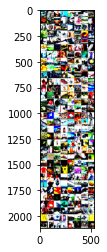

In [23]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(BATCH_SIZE)))

## Test accuracy at each class level

In [24]:
   
misclassifiedimages = utl.get_validation_result_and_misclassifiedimages(net , device , classes , testloader ) 

Class accuracy 

Accuracy of Egyptian cat : 41 % 

Accuracy of  reel : 25 % 

Accuracy of volleyball : 53 % 

Accuracy of rocking chair : 46 % 

Accuracy of lemon : 67 % 

Accuracy of bullfrog : 68 % 

Accuracy of basketball : 64 % 

Accuracy of cliff : 43 % 

Accuracy of espresso : 77 % 

Accuracy of plunger : 19 % 


 Accuracy of the network on the 10000 test images: 54.42 %


## Test accuracy 54.42% (randomly picking a class out of 200 classes).
Seems like the network learnt something.

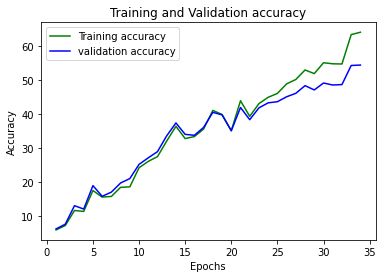

In [25]:
utl.plot_train_vs_test_accuracy(EPOCHS , train_acc , test_acc)

## Visualize misclassified test images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

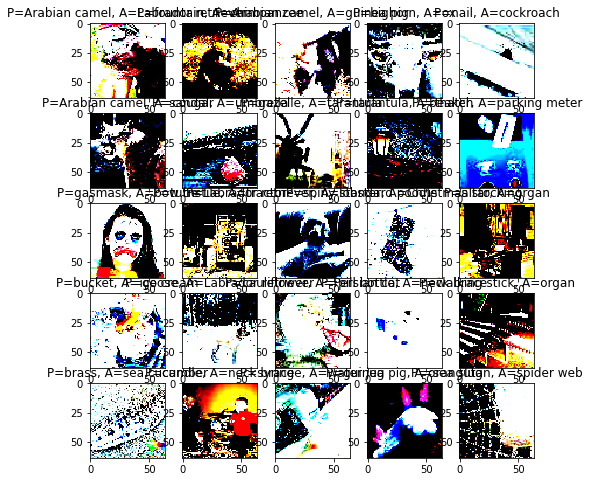

In [26]:
utl.view_misclassified_images(misclassifiedimages , classes)

In [27]:

import numpy as np
import matplotlib.pyplot as plt

def imshowgradcam(img,c = "" ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

## GradCam of misclassified images

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2941: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or 

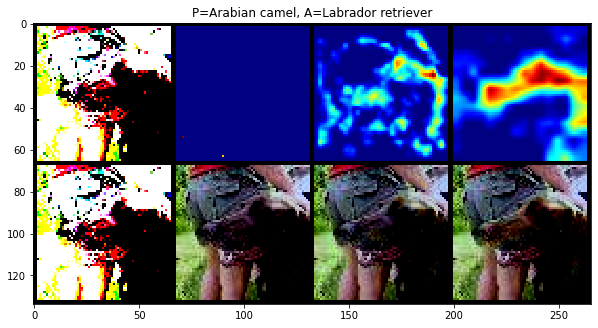

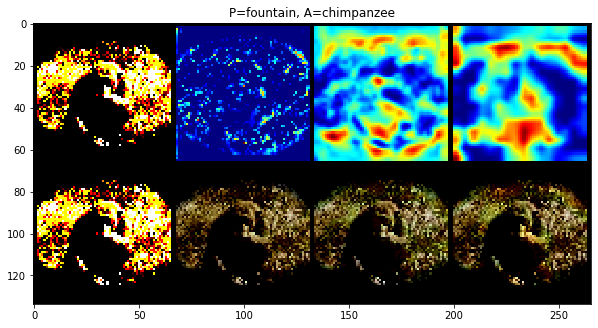

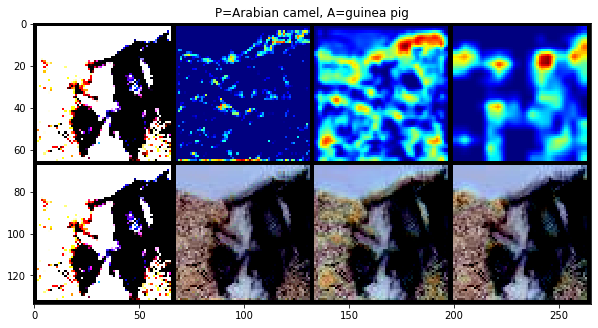

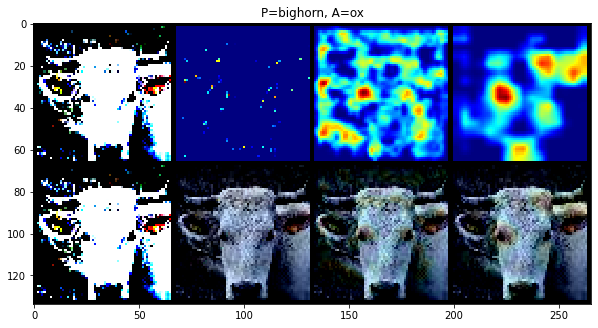

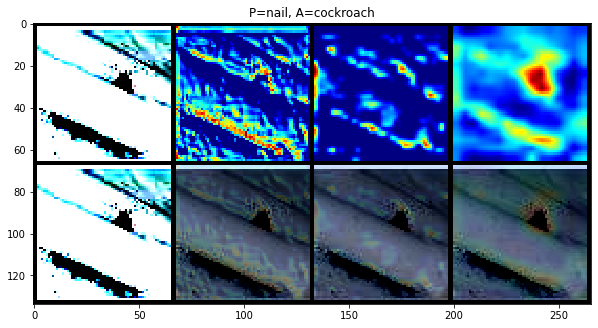

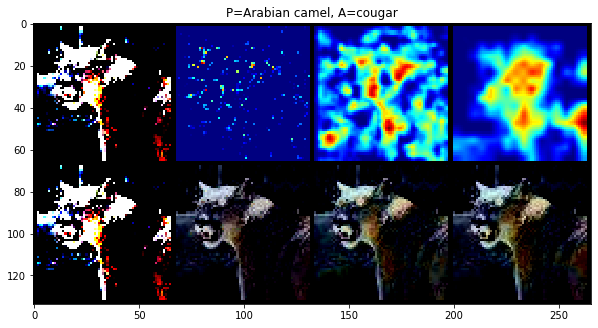

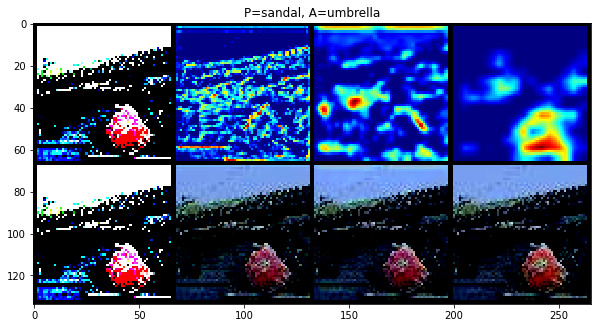

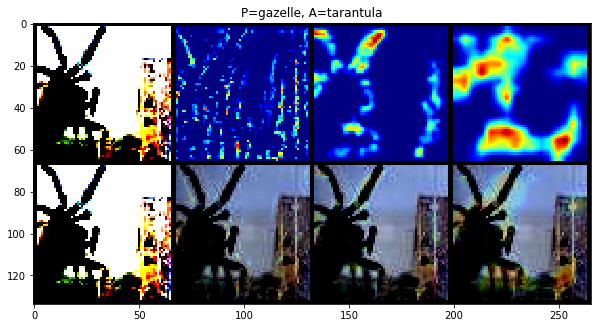

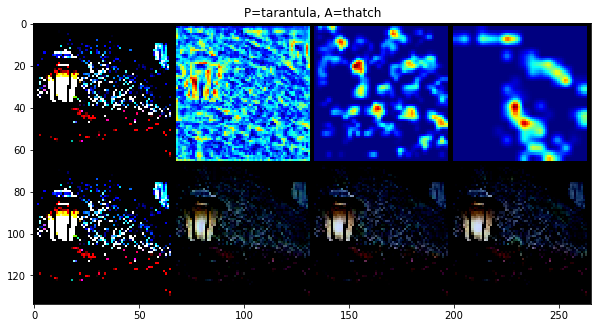

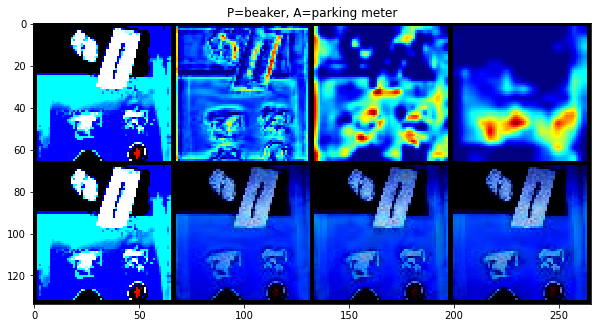

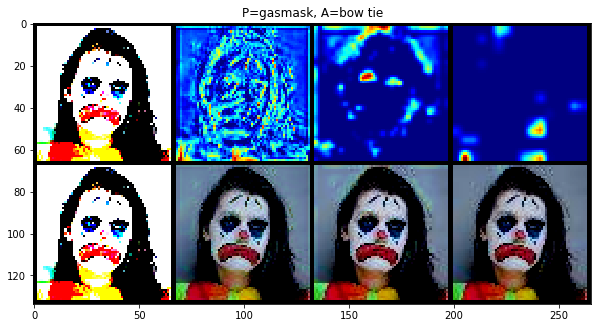

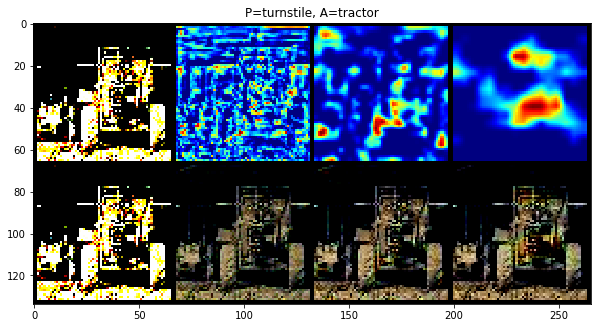

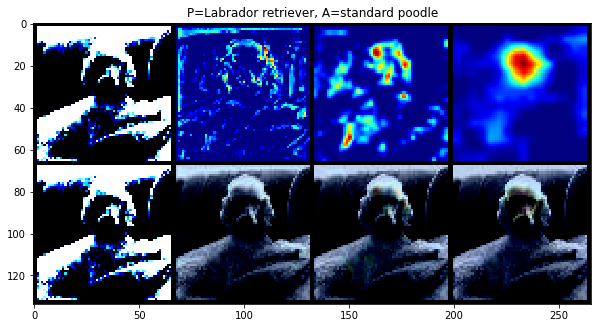

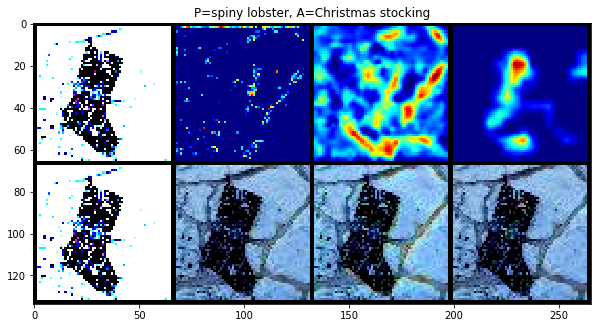

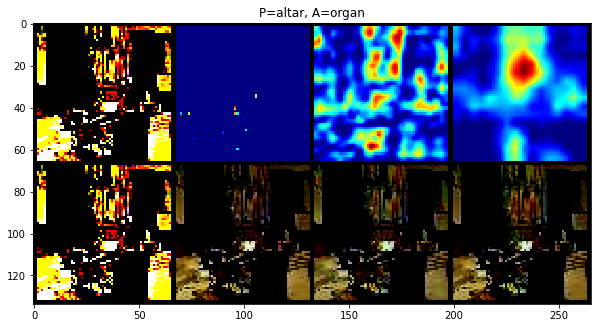

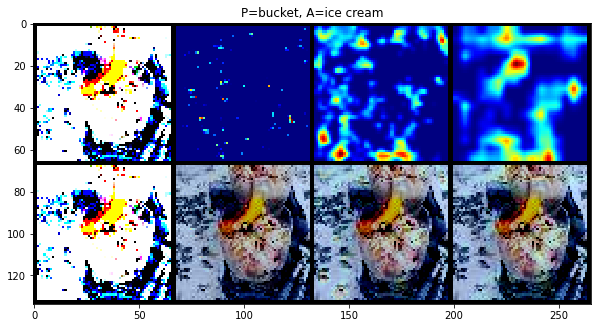

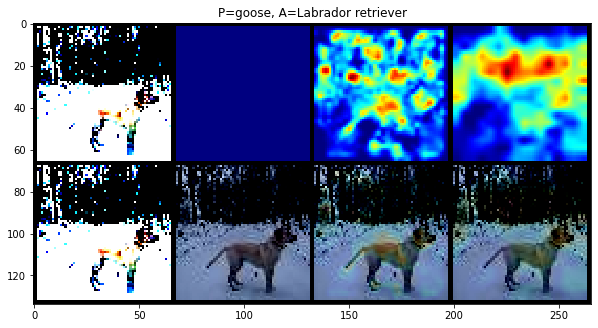

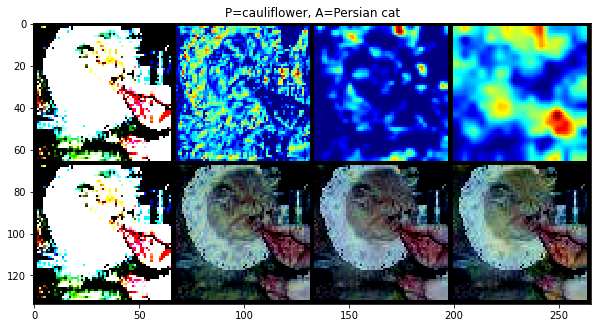

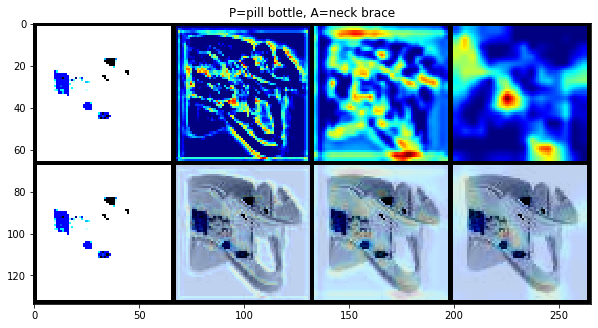

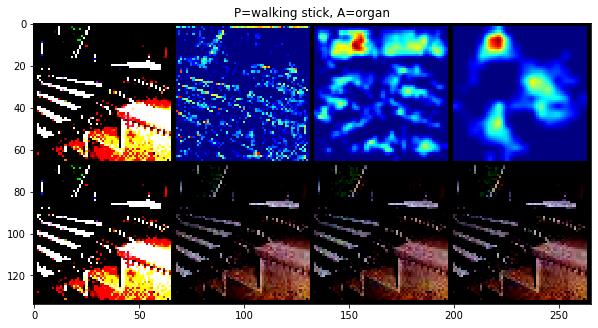

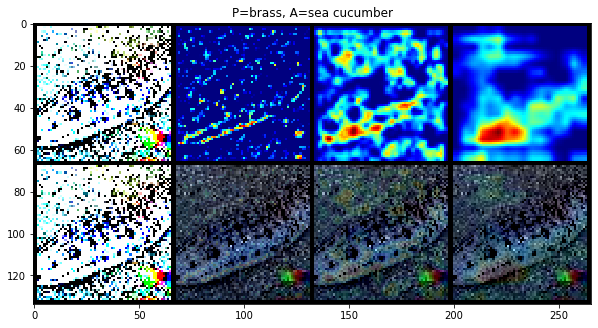

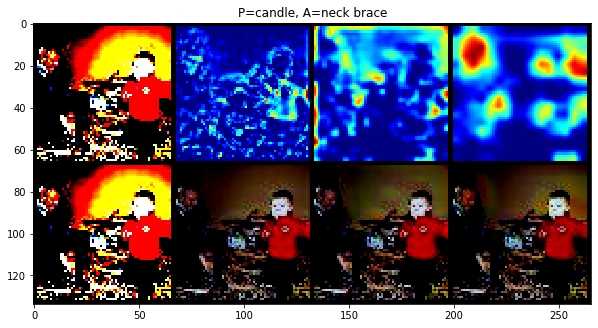

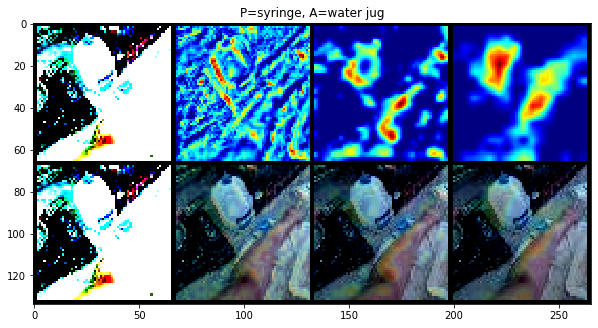

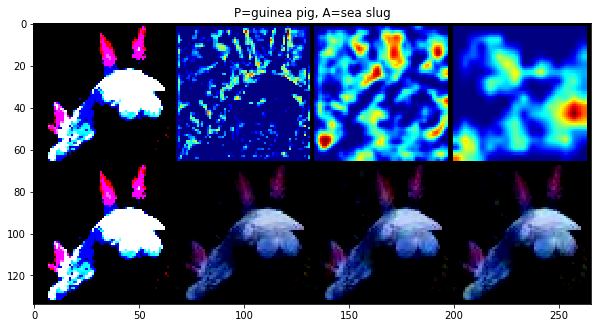

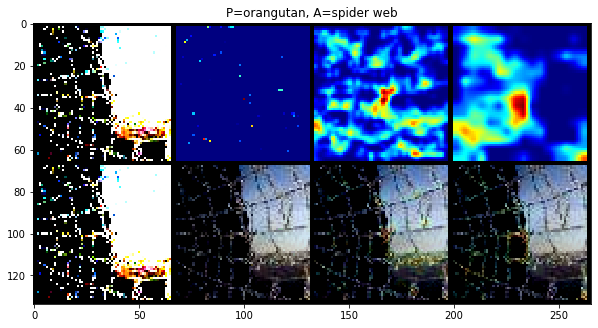

In [28]:
import copy
from torchvision.utils import make_grid, save_image
for i,k in enumerate(misclassifiedimages):
  images1 = [misclassifiedimages[i][0].cpu()]
  images2 =  [misclassifiedimages[i][0].cpu()]
  b = copy.deepcopy(net.to(device))
  output = net(misclassifiedimages[i][0].unsqueeze(0))
  _, predicted = torch.max(output.data, 1)
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = utl.GradCAM(b,j)
    # mask, _= g(gradcam_misclassified_images[i][0].unsqueeze(0))
    # heatmap, result = visualize_cam(mask,gradcam_misclassified_images[i][0])
    mask, _= g(misclassifiedimages[i][0].clone().unsqueeze_(0))
    heatmap, result = utl.visualize_cam(mask,misclassifiedimages[i][0].clone().unsqueeze_(0)/2+0.5 )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2,nrow=5)
  # imshow(grid_image,c = classes[int(predicted)])
  imshowgradcam(grid_image,c = "P={}, A={}".format(str(classes[misclassifiedimages[i][1].data.cpu().numpy()]),str(classes[misclassifiedimages[i][2].data.cpu().numpy()])))